**Proyecto** final: Clasificación de estrellas, galaxias y cuásares

Carga de paqueterías necesarias

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Carga de datos

In [120]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"j0s34ng3l","key":"bb2315e34113edc4cd065f735d6b89bb"}'}

In [121]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [122]:
!kaggle datasets download -d lucidlenn/sloan-digital-sky-survey

sloan-digital-sky-survey.zip: Skipping, found more recently modified local copy (use --force to force download)


In [123]:
!unzip -qq sloan-digital-sky-survey.zip

replace Skyserver_SQL2_27_2018 6_51_39 PM.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [124]:
!unzip -qq train.zip

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [125]:
SDSS_data = pd.read_csv("/content/Skyserver_SQL2_27_2018 6_51_39 PM.csv")

Visualización de los datos

In [126]:
SDSS_data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


Explicamos que significa cada una de las columnas:

-*ra, dec*: ascensión recta(*right ascension*) y declinación(*declination*) respectivamente

-*u, g, r, i, z*: Bandas de filtro (también conocidas como sistema fotométrico o magnitudes astronómicas)

-*run, rerun, camcol, field*: descriptores de campos (es decir, 2048 x 1489 píxeles) dentro de la imagen

-*redshift* (corrimiento al rojo): aumento de la longitud de onda debido al movimiento del objeto astronómico

-*plate*: número de placa

-*mjd*: fecha juliana modificada de observación

-*fiberid*: ID de fibra óptica

Las variables 'run', 'rerun', 'camcol' y 'field' describen un campo dentro de una imagen tomada por el SDSS. Un campo es básicamente una parte de toda la imagen correspondiente a 2048 por 1489 píxeles.

Un campo se puede identificar por:
- Número *run*: identifica el escaneo específico
- Columna de la cámara, o *camcol*: un número del 1 al 6, que identifica la línea de escaneo dentro de la ejecución.
- Número *field*: Generalmente comienza en 11 (después de un tiempo de aceleración inicial) y puede ser tan grande como 800 para tiradas particularmente largas.
- Un número adicional, *rerun* , especifica cómo se procesó la imagen.

**Análisis estadístico**

Separamos la columna 'objid' ya que nos servirá más tarde

In [127]:
SDSS_objid = SDSS_data['objid']

Eliminamos columnas 'rerun', 'specobjid' y 'objid' ya que no aporta información relevante para el análisis

In [128]:
SDSS_data=SDSS_data.drop(['objid','specobjid', "rerun"],axis=1)

La columna *Class* nos indica el tipo de objeto astronómico, nos da las etiquetas de los objetos a analizar

In [129]:
SDSS_features = SDSS_data.drop("class",axis=1) #Características
SDSS_labels = SDSS_data['class'] #Etiquetas

In [130]:
SDSS_data

,ra,dec,u,g,r,i,z,run,camcol,field,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,4,267,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,4,267,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,4,268,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,4,269,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,4,269,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,3,161,GALAXY,0.027583,447,51877,246
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,3,162,GALAXY,0.117772,447,51877,228
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,3,162,STAR,-0.000402,7303,57013,622
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,3,163,GALAXY,0.014019,447,51877,229


Realizamos un análisis estadístico rápido de los datos

El dataset consiste de 10,000 observaciones del espacio tomadas por el Sloan Digital Sky Survey (SDSS). Cada observación se describe mediante 17 columnas de características y 1 columna de clase que la identifica como estrella, galaxia o quásar.

In [ ]:
SDSS_data.shape, SDSS_data.describe()

((10000, 15),
                  ra           dec             u             g             r  \
 count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
 mean     175.529987     14.836148     18.619355     17.371931     16.840963   
 std       47.783439     25.212207      0.828656      0.945457      1.067764   
 min        8.235100     -5.382632     12.988970     12.799550     12.431600   
 25%      157.370946     -0.539035     18.178035     16.815100     16.173333   
 50%      180.394514      0.404166     18.853095     17.495135     16.858770   
 75%      201.547279     35.649397     19.259232     18.010145     17.512675   
 max      260.884382     68.542265     19.599900     19.918970     24.802040   
 
                   i             z           run        camcol         field  \
 count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
 mean      16.583579     16.422833    981.034800      3.648700    302.380100   
 std        1.141805    

Text(0.5, 1.0, 'Histograma de clases')

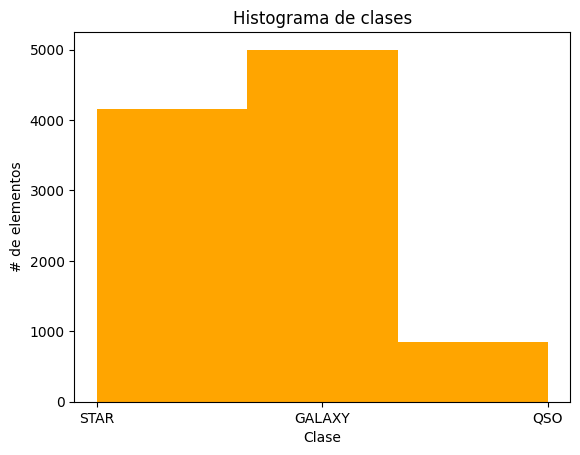

In [131]:
plt.hist(SDSS_data["class"],bins=3, color='orange')
plt.xlabel('Clase')
plt.ylabel('# de elementos')
plt.title('Histograma de clases')

La columna *Class* no es numérica, por lo que aplicamos un one-hot encoder



In [ ]:
SDSS_labels = pd.get_dummies(pd.Series(SDSS_labels)) #One-hot encoding

Separamos en datos de entrenamiento y prueba

In [ ]:
SDSS_training = SDSS_features.sample(frac=0.8,random_state=0)
SDSS_test = SDSS_features.drop(SDSS_training.index)

In [ ]:
SDSS_objid_training = SDSS_objid.sample(frac=0.8,random_state=0)
SDSS_objid_test = SDSS_objid.drop(SDSS_objid_training.index)

Definimos una función de normalización

In [ ]:
def norm(train_data, test_data):
  mean = train_data.mean(axis=0)
  std = train_data.std(axis=0)
  train_data -= mean
  train_data /= std
  test_data -= mean
  test_data /= std
  return train_data, test_data

SDSS_training, SDSS_test = norm(SDSS_training, SDSS_test)

Separamos las etiquetas de entrenamiento y de prueba

In [ ]:
train_labels = SDSS_labels.sample(frac=0.8,random_state=0)
test_labels = SDSS_labels.drop(train_labels.index)
train_labels = SDSS_objid.sample(frac=0.8,random_state=0)
test_labels = SDSS_objid.drop(train_labels.index)

Construcción del modelo de la red:
Primer modelo, de 3 capas densas de 64 neuronas para las primeras 2 y 3 para la última.

In [132]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(SDSS_training.keys() )]),
      layers.Dense(64, activation='relu'),
      layers.Dense(3) # 3 clases: STAR, GALAXY, QSO
  ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

Compilar modelo

In [ ]:
#Agregamos un callback para el progreso por épocas
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [133]:
model = build_model()
history = model.fit(SDSS_training, train_labels,
          epochs=120, batch_size=16, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................

In [ ]:
test_mse_score, test_mae_score = model.evaluate(SDSS_test, test_labels)

625/625 [==============================] - 1s 2ms/step - loss: 0.0087 - mae: 0.0232


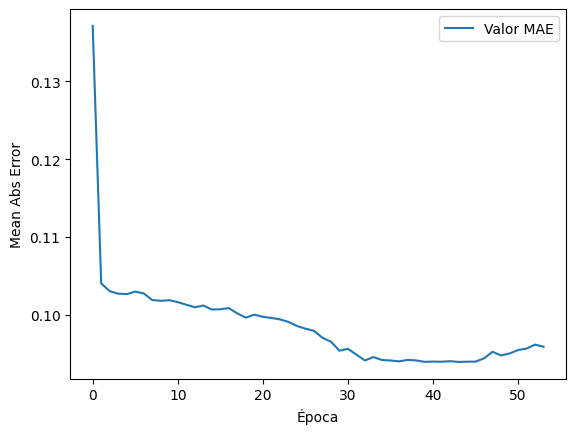

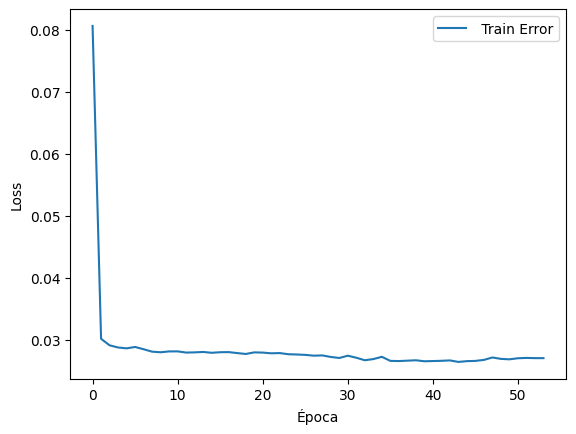

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.plot(hist['epoch'],hist['mae'], label='Valor MAE')
plt.xlabel('Época')
plt.ylabel('Mean Abs Error')
plt.legend()

plt.figure()
plt.xlabel('Época')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label=' Train Error')
plt.legend()

plt.show()

**Segundo modelo: Agregando dropouts y regularizadores**

In [ ]:
from tensorflow.keras import regularizers
early_stop = keras.callbacks.EarlyStopping(monitor='mae', patience=10)

In [135]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, kernel_regularizer= regularizers.l2(0.002), activation='relu', input_shape=[len(SDSS_training.keys() )]),
      layers.Dropout(0.5),
      layers.Dense(64, kernel_regularizer= regularizers.l2(0.002), activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(3) # 3 clases: STAR, GALAXY, QSO
  ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [ ]:
model = build_model()
history = model.fit(SDSS_training, train_labels,
          epochs=120, batch_size=16, verbose=0, callbacks=[PrintDot(),early_stop])


...........................................................................

In [ ]:
test_mse_score, test_mae_score = model.evaluate(SDSS_test, test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 0.0228 - mae: 0.0310


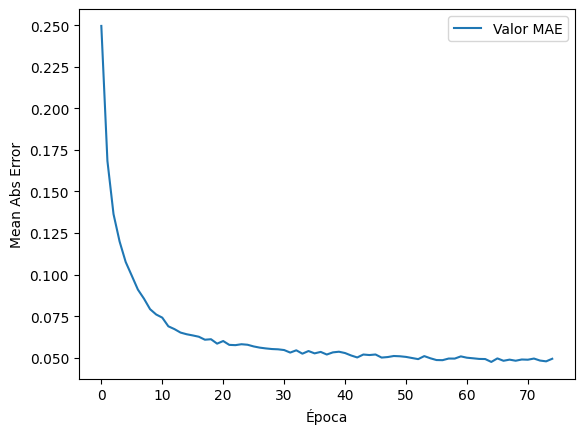

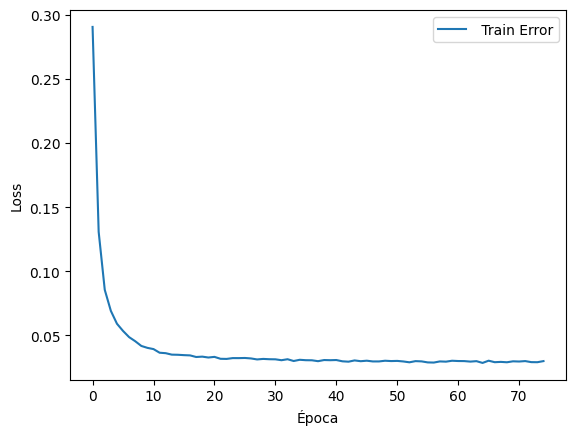

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.plot(hist['epoch'],hist['mae'], label='Valor MAE')
plt.xlabel('Época')
plt.ylabel('Mean Abs Error')
plt.legend()

plt.figure()
plt.xlabel('Época')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label=' Train Error')
plt.legend()

plt.show()

K-fold

In [134]:
def k_fold(train_data,train_targets):
  k = 4
  num_val_samples = len(train_data) // k
  num_epochs = 120
  all_scores = []
  for i in range(k):
      print(f"Procesando capa #{i}")
      val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
      val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
      partial_train_data = np.concatenate(
          [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
          axis=0)
      partial_train_targets = np.concatenate(
          [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
          axis=0)
      model = build_model()
      model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=16, verbose=0)
      val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
      all_scores.append(val_mae)
  return model, val_mse, val_mae, all_scores

In [ ]:
model,val_mse, val_mae, scores = k_fold(SDSS_training,train_labels)

Procesando capa #0
Procesando capa #1
Procesando capa #2
Procesando capa #3


In [ ]:
np.mean(scores)

0.03979308623820543

In [ ]:
def validation_logs(train_data, train_targets):
  k=3
  num_val_samples = len(train_data) // k
  num_epochs = 120
  mae_histories = []
  for i in range(k):
      print(f"Procesando capa #{i}")
      val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
      val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
      partial_train_data = np.concatenate(
          [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
          axis=0)
      partial_train_targets = np.concatenate(
          [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
          axis=0)
      model = build_model()
      history = model.fit(partial_train_data, partial_train_targets,
                          validation_data=(val_data, val_targets),
                          epochs=num_epochs, batch_size=16, verbose=0)
      mae_history = history.history["val_mae"]
      mae_histories.append(mae_history)
  return mae_histories, num_epochs

In [ ]:
mae_histories, num_epochs = validation_logs(SDSS_training, train_labels)

Procesando capa #0


Construímos varias puntuaciones de validación de distintas K-capas

In [ ]:
average_mae_history = [np.mean([x[i] for x in mae_histories]) for i in range(num_epochs)]

Graficamos los datos de validación

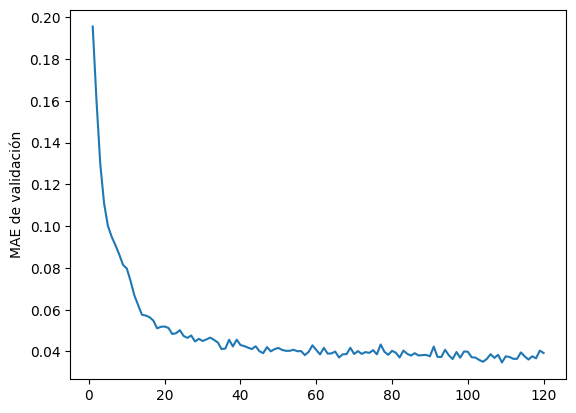

In [ ]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.ylabel("Épocas")
plt.ylabel("MAE de validación")
plt.show()

In [ ]:
model = build_model()
model.fit(SDSS_training, train_labels, epochs=120,batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(SDSS_test , test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 0.0236 - mae: 0.0361


Ahora agregamos una función de activación relu al segundo modelo para tener valores lo más cercanos a 1 o 0.

In [ ]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, kernel_regularizer= regularizers.l2(0.002), activation='relu', input_shape=[len(SDSS_training.keys() )]),
      layers.Dropout(0.5),
      layers.Dense(64, kernel_regularizer= regularizers.l2(0.002), activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(3, activation='relu') # 3 clases: STAR, GALAXY, QSO
  ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

Realizamos predicciones con nuestro último modelo y los comparamos con los datos de prueba

In [ ]:
predictions = model.predict(SDSS_test)
predictions[:10]

63/63 [==============================] - 0s 2ms/step


array([[0.        , 0.        , 0.9728353 ],
       [0.        , 0.        , 0.9800147 ],
       [0.        , 0.        , 0.944303  ],
       [1.0136577 , 0.        , 0.        ],
       [0.86678255, 0.        , 0.        ],
       [0.        , 0.        , 0.9799733 ],
       [0.        , 0.        , 0.96648896],
       [0.        , 0.        , 0.9693716 ],
       [1.006786  , 0.        , 0.        ],
       [0.98356205, 0.        , 0.        ]], dtype=float32)

In [ ]:
predictions

array([[0.        , 0.        , 0.96402293],
       [0.        , 0.        , 0.97575396],
       [0.        , 0.        , 0.96008784],
       ...,
       [0.        , 0.        , 0.98040336],
       [0.        , 0.        , 0.94985735],
       [0.8308594 , 0.        , 0.        ]], dtype=float32)

In [ ]:
test_labels

,GALAXY,QSO,STAR
0,0,0,1
13,0,0,1
21,0,0,1
25,1,0,0
26,1,0,0
...,...,...,...
9963,0,0,1
9969,1,0,0
9972,0,0,1
9982,0,0,1


Obtenemos el error entre las predicciones y los datos de prueba

(array([[2.000e+01, 4.000e+00, 1.100e+01, 1.900e+01, 1.804e+03, 9.300e+01,
         1.400e+01, 1.500e+01, 1.100e+01, 9.000e+00],
        [7.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 1.937e+03, 2.700e+01,
         4.000e+00, 2.000e+00, 4.000e+00, 6.000e+00],
        [1.400e+01, 6.000e+00, 1.100e+01, 1.300e+01, 1.908e+03, 1.700e+01,
         9.000e+00, 6.000e+00, 3.000e+00, 1.300e+01]]),
 array([-1.        , -0.7969411 , -0.5938822 , -0.3908233 , -0.18776441,
         0.01529449,  0.21835339,  0.42141229,  0.62447119,  0.82753009,
         1.03058898]),
 <a list of 3 BarContainer objects>)

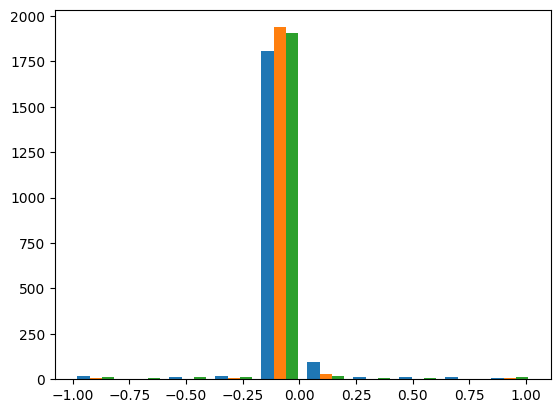

In [ ]:
error = predictions - test_labels
plt.hist(error)

Por último, es posible obtener las imágenes del SDSS a partir de la columna 'objectid' de la base de datos, para ello usamos el sig. script y

In [ ]:
SDSS_data=pd.concat((SDSS_data,SDSS_objid), axis=1)

In [ ]:
from astropy.table import Table
table = Table.from_pandas(SDSS_data)
file = 'lista.fits'
table.write(file, format='fits',overwrite=True)

In [ ]:
hdulist[1]

In [ ]:
import webbrowser
import urllib.request
import astropy.io.fits as pyfits
import os
import numpy as np

file='lista.fits'
hdulist=pyfits.open(file)
tbdata = hdulist[1].data
name = tbdata.field('objid')
ra = tbdata.field('ra')
dec = tbdata.field('dec')
#petro = tbdata.field('Re')

for i in range(20):
#     scale = 12*petro[i]/350.
     scale = 0.369
# Download from SDSS
     url1 = 'https://skyserver.sdss.org/dr18/SkyServerWS/ImgCutout/getjpeg?ra=%f&dec=%f&scale=%f&width=512&height=512&opt=' % (ra[i], dec[i],scale)
# Save images from url
     urllib.request.urlretrieve(url1, str(name[i])+'-sdss.jpg')
     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


La imagen se guarda en un archivo .jpg en un directorio libre de especificar.